<a href="https://colab.research.google.com/github/aryan-at-ul/group_project_waves_predictions/blob/main/wave_related_notebooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install -U -q PyDrive

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link = "https://drive.google.com/file/d/1-xJ06pAoGX6bo3b9wK9FCsONluI9MpBW/view?usp=sharing"
idd = link.split("/")[-2]
print(idd)
downloaded = drive.CreateFile({'id':idd})
print(downloaded)
downloaded.GetContentFile('bouy_data_hourly_mean.csv')

1-xJ06pAoGX6bo3b9wK9FCsONluI9MpBW
GoogleDriveFile({'id': '1-xJ06pAoGX6bo3b9wK9FCsONluI9MpBW'})


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

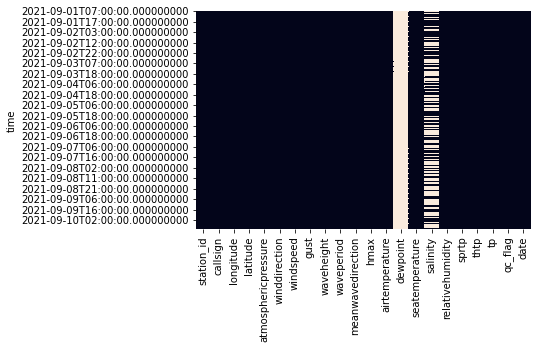

In [5]:
df = pd.read_csv("bouy_data_hourly_mean.csv",parse_dates=["time"],index_col=["time"])
df.head()
sns.heatmap(df[-1000:].isnull(), cbar=False)

In [6]:
station_names_set = set(df["station_id"])
size = df.shape[0]

# for station in station_names_set:
#     mask = df["station_id"].values == station
#     size = df.shape[0]
#     station_obs_size = mask.sum()
#     sns_plot = sns.heatmap(df[mask].isnull(), cbar=False)
#     sns_plot.figure.savefig(f"/content/output/null_spread_at_{station}_{station_obs_size}_{size}.png")

# next stuff done on m5 data as it has minimun null values 

In [7]:
df.shape

(748045, 22)

In [ ]:
for station in station_names_set:
    mask = df["station_id"].values == station
    station_obs_size = mask.sum()
    print(f"null values at station : {station} , with total observation of {station_obs_size}")
    print(df[mask].isnull().sum(axis=0))
    print("===================================")

In [ ]:
for station in station_names_set:
    mask = df["station_id"].values == station
    station_obs_size = mask.sum()
    df_st_series = df[mask].isnull().sum(axis=0)
    print(f"null values at station : {station} ,with observation of {station_obs_size} out of {size}")
    # print(df[mask].isnull().sum(axis=0))
    df_st_series.plot(kind='bar',title = f"null per cols for station {station}")
    plt.show()

below we try to impute missing values using cubic method, and then plot them, those fit looks logical

In [ ]:
#pd.options.mode.chained_assignment = None
#mask = df["station_id"].values == "M5"  # could get wrong but this is fast
mask = df.loc[df.station_id == "M5" ]
df_m5 = mask#df[mask]
df_m5.drop(['date','station_id','callsign','longitude','latitude','qc_flag','tp','qc_flag','thtp','sprtp'],axis = 1, inplace=True)
print(df_m5.columns)
#df_m5 = df_m5[0:1500]
print(df_m5.shape)
null_mask = df_m5.isnull()
df_m5 = df_m5.interpolate(method="time",axis = 0).ffill().bfill()
imputed = df_m5[null_mask]
not_imputed = df_m5[~null_mask]
# ignore_cols = ['station_id','callsign','longitude','latitude','qc_flag','tp','qc_flag','thtp']
for c in df_m5.columns:
#     if c in ignore_cols:
#         continue
    print(f"plotting for col:{c}")
    plt.suptitle(f'{c} at station M5')
    plt.plot(df_m5[c],color = 'r')
    plt.plot(not_imputed[c],color = 'r', marker = 'o')
    plt.plot(imputed[c],linestyle = '',color = 'b',marker = 'd')
    #plt.savefig(f'/content/plots/station_M5_{c}_imputation_results_small_range.png')
    plt.show()
    print("===============================")

In [11]:
#saving imputed csv file station wise
for station in station_names_set:
    mask = df.loc[df.station_id == station ]
    df_m5 = mask#df[mask]
    df_m5.drop(['date'],axis = 1, inplace=True)
    null_mask = df_m5.isnull()
    df_m5 = df_m5.interpolate(method="time",axis = 0).ffill().bfill()
    df_m5.to_csv(f"{station}_interpolated_data.csv",index=False)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
from IPython.display import Math,display,HTML
import math

In [13]:
display(HTML("""<a href = "https://en.wikipedia.org/wiki/Wave_power">wave power wiki</a>"""))
display(Math("\\text{Wave power formula = } \\frac{\\rho g^2}{64 \\pi}{H_{m0}^2 T_{e}}"))

<IPython.core.display.Math object>

assuming wave height = waveheight in csv , wave period is wave period in csv , density is $$\rho = 1000kg/m^3$$ and Te being wave period 

##Not sure about units in csv file

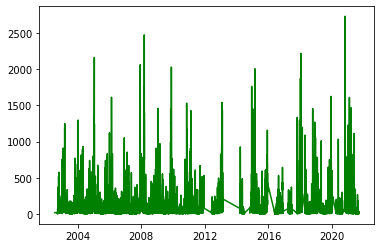

In [14]:
# adding a col that represents power at a point
def power_at_a_time(row):
    density = 1000.0
    gravity = 9.8 
    const = (density * gravity ** 2) / (64.0 * math.pi)
    power = (row['waveheight'] ** 2 ) * row['waveperiod']
    return power
#formula from wifipedia
df_m5['power'] = df_m5.apply(lambda row: power_at_a_time(row),axis = 1)
df_m5.head()
plt.plot(df_m5['power'],color = 'g')
plt.show()


In [15]:
df_m5.describe().T.style.bar(subset=['mean'],color='#205ef2').background_gradient(subset=['std'],cmap='Greens').background_gradient(subset=['50%'],cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
callsign,130637.000000,62092.000000,0.000000,62092.000000,62092.000000,62092.000000,62092.000000,62092.000000
longitude,130637.000000,-10.548261,0.000000,-10.548261,-10.548261,-10.548261,-10.548261,-10.548261
latitude,130637.000000,51.215956,0.000000,51.215956,51.215956,51.215956,51.215956,51.215956
atmosphericpressure,130637.000000,1014.618072,11.722348,910.200000,1007.568757,1015.800000,1022.800000,1045.600000
winddirection,130637.000000,200.461270,96.052968,0.000000,120.000000,210.000000,280.000000,360.000000
windspeed,130637.000000,15.374525,6.811353,0.000000,10.519573,15.000000,20.000000,45.000000
gust,130637.000000,20.877138,9.174878,0.000000,15.000000,20.000000,26.000000,181.000000
waveheight,130637.000000,2.855832,1.575725,0.200000,1.719000,2.500000,3.594000,14.063000
waveperiod,130637.000000,6.882846,1.511591,2.000000,6.000000,7.000000,8.000000,14.414000
meanwavedirection,130637.000000,253.866986,36.337090,0.000000,250.000000,250.000000,259.000000,359.000000


(130637, 22)

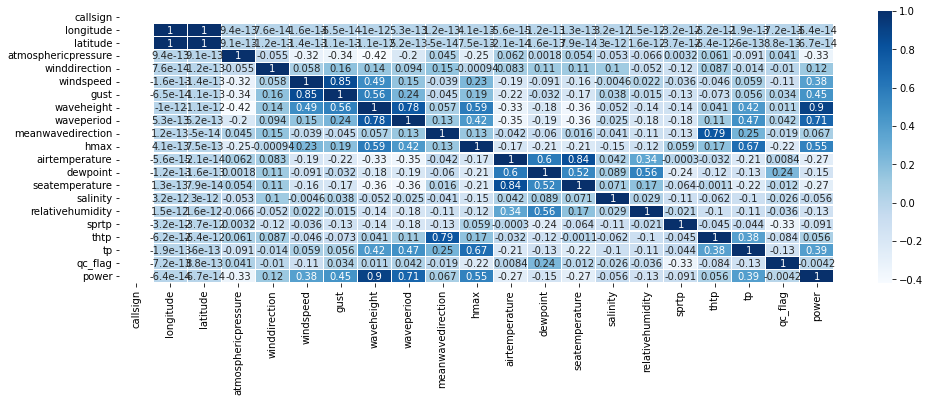

In [16]:
# some cols dont seem to have any kind of impact on power , so many in case of a multivariate model ,
# we need tp predict height and wave freq (freq can depend on wind speed etc)
corr = df_m5.corr()
plt.figure(figsize=(16,5))
sns.heatmap(corr,cmap= 'Blues',annot=True,linewidths=.5)
# useless !!!!
df_m5.shape

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


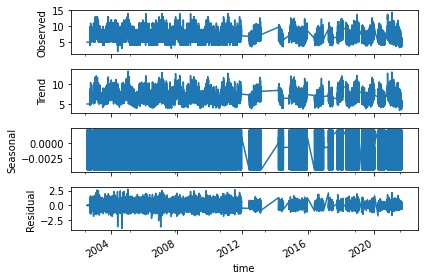

In [18]:
#analysis = df_m5[['waveheight']].copy()
decompose_result_mult = seasonal_decompose(df_m5['waveperiod'], model="additive",freq=10)
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid
decompose_result_mult.plot();

In [25]:
#monthly min max  # to do more on season trends etc 
# plt.figure(figsize=(10,7))
# timestep = df_m5.index.to_numpy()
# #print(timestep)
# res = df_m5.resample(rule='M').mean()
# print(res)
# timestep = res.index.to_numpy()
# vals = res['waveheight'].to_numpy()
# print(vals)

#plot_time_series(timestep,vals)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [26]:
df_m5.shape
df_m5.columns
df_m5_copy = df_m5.copy()
df_m5_copy = df_m5_copy.resample('M').mean()
df_m5_copy = df_m5_copy.interpolate(method="time",axis = 0).ffill().bfill()
df_m5_copy.index = pd.DatetimeIndex(df_m5_copy.index).to_period('M')
train_data = df_m5_copy.iloc[:int(0.8 * len(df_m5_copy.index))-1]
test_data = df_m5_copy.iloc[int(0.8 * len(df_m5_copy.index)):]

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [27]:
model_1 = exp_smooth = ExponentialSmoothing(endog=train_data['waveheight'], 
                                  damped=True, 
                                  dates=None,
                                  freq=None,                                  
                                  missing='none', 
                                  seasonal='mul', 
                                  seasonal_periods=12, 
                                  trend='mul')
model_1_fitted = model_1.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:939: RuntimeWarning: divide by zero encountered in double_scalars
  'initial_slope': b[0] / phi,


In [28]:
model_1_fitted = ExponentialSmoothing(train_data['waveheight'],trend = 'mul', seasonal='mul' , seasonal_periods = 12).fit()

In [29]:
test_predictions = model_1_fitted.forecast(40) 

In [ ]:
test_predictions

2018-05    1.862155
Freq: M, dtype: float64

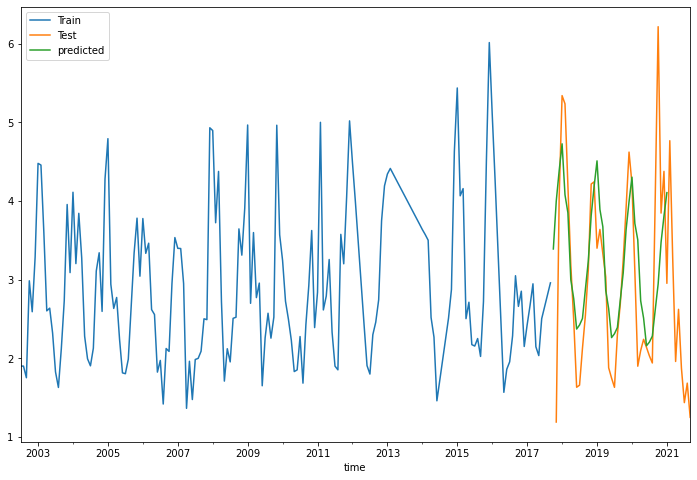

In [30]:
train_data['waveheight'].plot(legend=True,label='Train',figsize = (12,8))
test_data['waveheight'].plot(legend=True,label='Test')
test_predictions.plot(legend=True,label = 'predicted')

# below here we are trying to replicate some know models and evaluate predictions using error functions and some plots 


In [31]:
import os 
import sys
import tensorflow as tf

In [32]:
def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # implement for season if one knows the season
  return mae / mae_naive_no_season

In [33]:
def evaluate_preds(y_true, y_pred):
    #all values should be as small as possible
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [34]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None,figname = None):

    # Plot the series do not pass df 
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("time")
    plt.ylabel("y values")
    if label:
        plt.legend(fontsize=14) # make label bigger
    if figname:
        plt.savefig(f'{figname}.png')
    plt.grid(True)

In [35]:
# creating train and test split
timesteps = df_m5.index.to_numpy()
waveperiod = df_m5["waveperiod"].to_numpy()
timesteps[:10], waveperiod[:10]

(array([Timestamp('2002-07-22 14:00:00+0000', tz='UTC'),
        Timestamp('2002-07-22 15:00:00+0000', tz='UTC'),
        Timestamp('2002-07-22 16:00:00+0000', tz='UTC'),
        Timestamp('2002-07-22 17:00:00+0000', tz='UTC'),
        Timestamp('2002-07-22 18:00:00+0000', tz='UTC'),
        Timestamp('2002-07-22 19:00:00+0000', tz='UTC'),
        Timestamp('2002-07-22 20:00:00+0000', tz='UTC'),
        Timestamp('2002-07-22 21:00:00+0000', tz='UTC'),
        Timestamp('2002-07-22 22:00:00+0000', tz='UTC'),
        Timestamp('2002-07-22 23:00:00+0000', tz='UTC')], dtype=object),
 array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]))

In [36]:
split_size = int(0.8 * len(waveperiod))

In [37]:
X_train, y_train = timesteps[:split_size], waveperiod[:split_size]
X_test, y_test = timesteps[split_size:], waveperiod[split_size:]
len(X_train), len(X_test), len(y_train), len(y_test)

(104509, 26128, 104509, 26128)

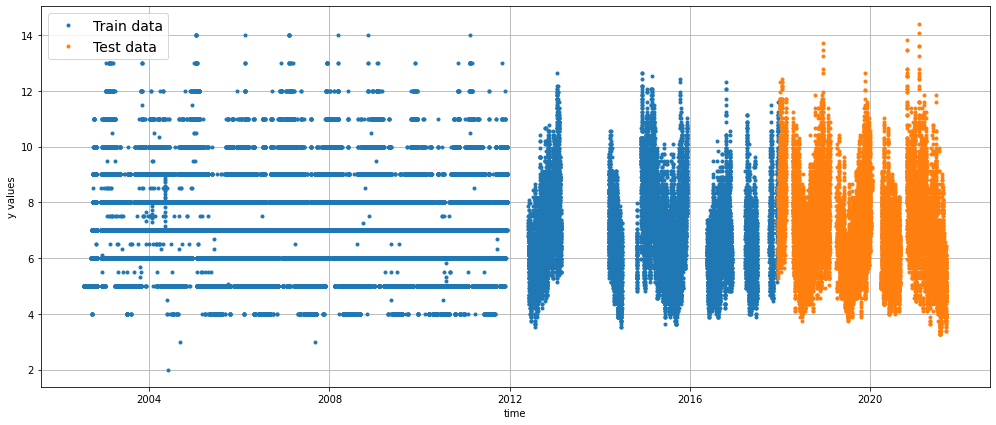

In [38]:
#plotting train test set but fig would be ugly 
# plt.figure(figsize=(17, 10))
# plt.scatter(X_train, y_train, s=2, label="Train data")
# plt.scatter(X_test, y_test, s=2, label="Test data")
# plt.xlabel("Date")
# plt.ylabel("waveperiod")
# plt.legend(fontsize=14)
# plt.show();
plt.figure(figsize=(17, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data",figname = 'train_and_test_split')


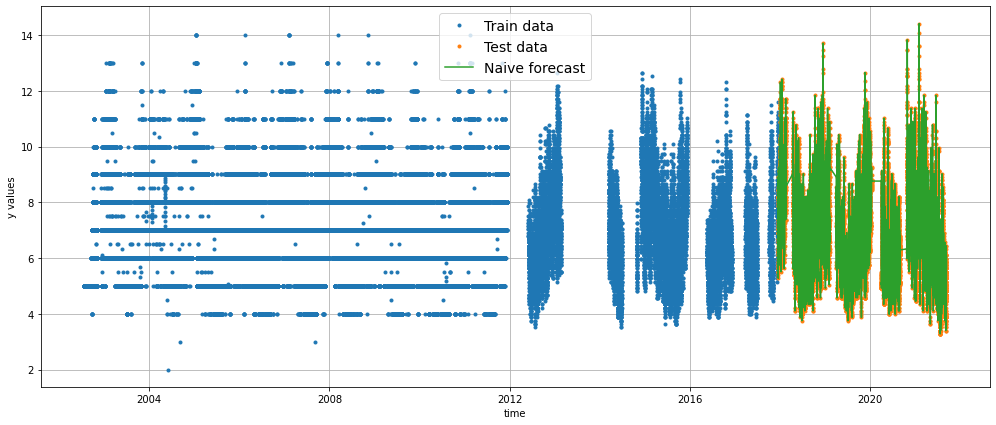

In [39]:
# testing shifiting , like value at t = value at t - 1  
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:]

plt.figure(figsize=(17, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast",figname="prediction_naive");

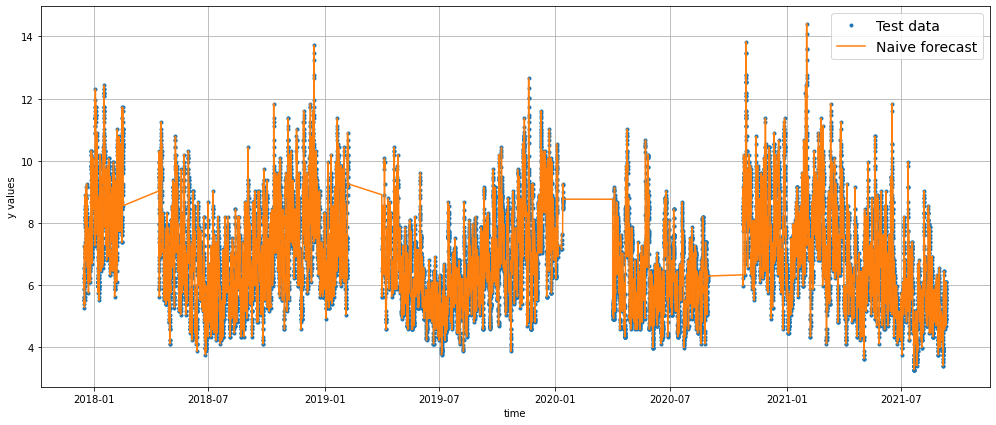

In [40]:
# there is some issue with data need to check it manually , lets try some other plots
plt.figure(figsize=(17, 7))
offset = 0
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast",figname='naive_fore_cast');

In [41]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 0.20839462,
 'mape': 2.9811568,
 'mase': 1.000134,
 'mse': 0.09066653,
 'rmse': 0.30110884}

In [42]:
HORIZON = 1  # how far in the future 
WINDOW_SIZE = 7 # how far in the past // lets do for 1 day at a time , there are methods to calculate confidence interval and stuff

In [43]:
def get_labelled_windows(x, horizon=1):
    #splitting data into two , past and future 
    return x[:, :-horizon], x[:, -horizon:]

In [44]:
def make_windows(x, window_size=7, horizon=1):
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [45]:
#test 
full_windows, full_labels = make_windows(waveperiod, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [5. 5. 5. 5. 5. 5. 5.] -> Label: [5.]
Window: [5. 5. 5. 5. 5. 5. 5.] -> Label: [5.]
Window: [5. 5. 5. 5. 5. 5. 5.] -> Label: [5.]


In [46]:
def make_train_test_splits(windows, labels, test_split=0.2):
    split_size = int(len(windows) * (1-test_split)) 
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [47]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)


np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

In [48]:
def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), 
                                                verbose=0,
                                                save_best_only=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")                         
], name="model_1_dense") # model name 1 

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) 

# Fit model , some thing is wrong with this part overfitting
model_1.fit(x=train_windows, # train windows of 7 timesteps of waveperiod 1-7 days and then 7th day the target 
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day) a bit like naive 
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

In [50]:
model_1.evaluate(test_windows, test_labels)
print(test_windows,"======================",test_labels)
#model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
#model_1.evaluate(test_windows, test_labels)

817/817 [==============================] - 1s 1ms/step - loss: 0.2085 - mae: 0.2085
[[8.203 8.086 7.734 ... 7.148 7.266 6.328]
 [8.086 7.734 7.5   ... 7.266 6.328 6.563]
 [7.734 7.5   7.148 ... 6.328 6.563 6.211]
 ...
 [5.742 5.742 6.094 ... 5.391 5.391 5.508]
 [5.742 6.094 5.742 ... 5.391 5.508 5.508]
 [6.094 5.742 5.391 ... 5.508 5.508 5.625]] ====================== [[6.563]
 [6.211]
 [6.211]
 ...
 [5.508]
 [5.625]
 [5.508]]


In [51]:
# caution !!!!!
def make_preds(model, input_data):
    #print(input_data[0])
    forecast = model.predict(input_data)
    print(forecast)
    return tf.squeeze(forecast)

In [52]:
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

[[6.355953 ]
 [6.557151 ]
 [6.2178016]
 ...
 [5.5001106]
 [5.501409 ]
 [5.6129713]]


(26126, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([6.355953 , 6.557151 , 6.2178016, 6.2073317, 6.5400987, 5.877716 ,
        6.0873666, 6.19855  , 5.8657646, 5.632701 ], dtype=float32)>)

In [53]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 0.20849991,
 'mape': 2.9854147,
 'mase': 1.0006443,
 'mse': 0.08904973,
 'rmse': 0.298412}

26126 [6.563 6.211 6.211 ... 5.508 5.625 5.508]


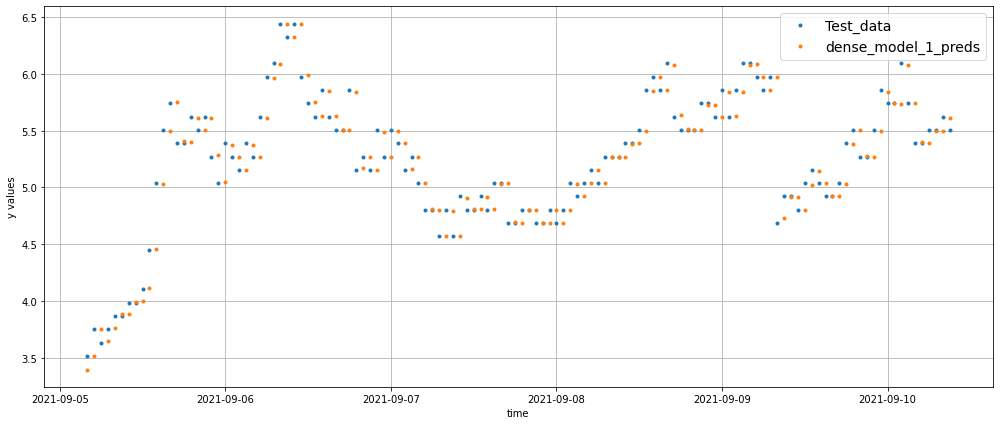

In [54]:
offset = 26000
plt.figure(figsize=(17, 7))
#  test again for correct window
print(len(test_windows),test_labels[:,0])
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset,format=".", label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format=".", label="dense_model_1_preds",figname='dense_model_prediciton_most_recent')

In [55]:
import numpy as np
from numpy.fft import rfft, rfftfreq
from scipy.signal import tukey
#from numpy import fft

In [ ]:
fft = np.fft.fft(waveperiod)
plt.figure(figsize=(14, 7), dpi=100)
# can use M5 station , there are a hige bunch missing in between interpolated stuff is not good , smooth but not good
for num_ in [150]:
    fft_list = np.copy(fft)
    fft_list[num_:-num_] = 0
    t = np.fft.ifft(fft_list)
    plt.plot(np.concatenate([t,t]), color = 'red',linewidth = 1)

#plt.plot(np.arange(0, waveperiod.size), waveperiod, 'b', linewidth = 0.1)
plt.show()

plt.figure(figsize=(14, 7), dpi=100)
plt.plot(waveperiod,color = 'b',linewidth = 0.1)
plt.show()

In [57]:

def evaluate_preds2(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)


    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    if mae.ndim > 0: 
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [58]:
# 2nd model

HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(waveperiod, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(104480, 26121, 104480, 26121)

In [ ]:
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [60]:
model_2.evaluate(test_windows, test_labels)


817/817 [==============================] - 1s 1ms/step - loss: 0.4087


0.40873050689697266

In [61]:
model_2 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_2.evaluate(test_windows, test_labels)

817/817 [==============================] - 1s 1ms/step - loss: 0.4076


0.4076294004917145

In [62]:
model_2_preds = make_preds(model_2,
                           input_data=test_windows)
model_2_preds[:5]

model_2_results = evaluate_preds2(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

[[7.243972  7.273045  7.2616506 ... 7.251186  7.292071  7.2694964]
 [6.3970733 6.406859  6.3941746 ... 6.4067616 6.474104  6.466794 ]
 [6.5565944 6.568272  6.5613756 ... 6.5634747 6.6009893 6.5801225]
 ...
 [5.7464905 5.7566056 5.7499013 ... 5.758601  5.780049  5.7863035]
 [5.7565794 5.7613187 5.762917  ... 5.7696443 5.7904396 5.787954 ]
 [6.0705605 6.0797234 6.0896    ... 6.0855513 6.0912876 6.0956674]]


{'mae': 0.40762916,
 'mape': 5.96262,
 'mase': 1.9562612,
 'mse': 0.35171574,
 'rmse': 0.46632275}

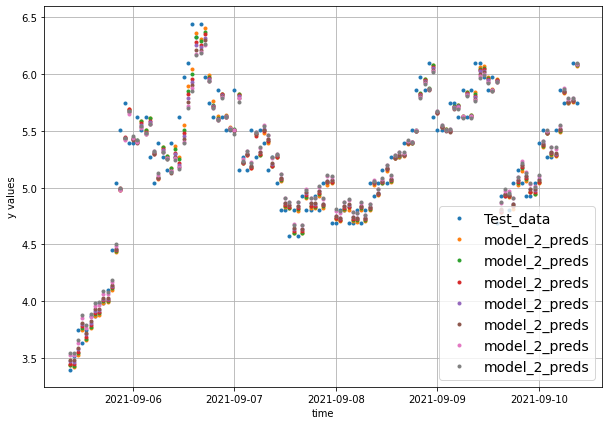

In [63]:
offset = 26000
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# not good 
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, label="model_2_preds")

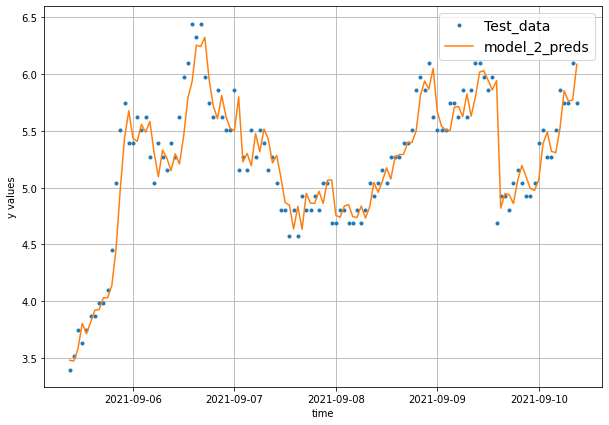

In [64]:
offset = 26000
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_2_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_2_preds")

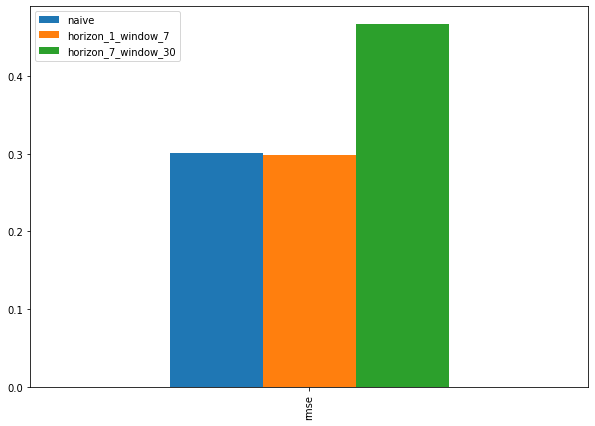

In [65]:
pd.DataFrame({"naive": naive_results["rmse"], 
              "horizon_1_window_7": model_1_results["rmse"], 
              "horizon_7_window_30": model_2_results["rmse"]}, index=["rmse"]).plot(figsize=(10, 7), kind="bar");

# orange is better

In [66]:
# model 3 , conv 1 d 

HORIZON = 1 
WINDOW_SIZE = 7

full_windows, full_labels = make_windows(waveperiod, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(104504, 26126, 104504, 26126)

In [ ]:
# this part is only for conv 1d , [ ] converted to [[]]
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) 
print(f"Original shape: {x.shape}") 
print(f"Expanded shape: {expand_dims_layer(x).shape}") 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

In [ ]:
model_3 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_conv1D")

# Compile model
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_3.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [ ]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_conv1D")
model_3.evaluate(test_windows, test_labels)

In [ ]:
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:10]

{'mae': 0.20868945, 'mse': 0.08910538, 'rmse': 0.29850525, 'mape': 2.992158, 'mase': 1.001554}


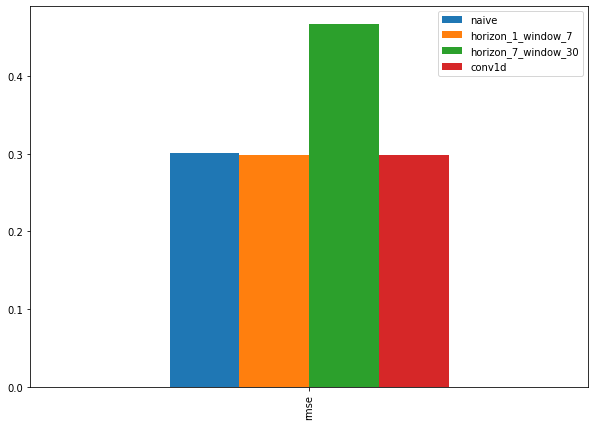

In [77]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
print(model_3_results)


pd.DataFrame({"naive": naive_results["rmse"], 
              "horizon_1_window_7": model_1_results["rmse"], 
              "horizon_7_window_30": model_2_results["rmse"],
              "conv1d":model_3_results["rmse"]}, index=["rmse"]).plot(figsize=(10, 7), kind="bar");


In [ ]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) 
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_4 = tf.keras.Model(inputs=inputs, outputs=output, name="model_4_lstm")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_4.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [73]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_lstm/")
model_4.evaluate(test_windows, test_labels)

817/817 [==============================] - 2s 2ms/step - loss: 0.2075


0.20753146708011627

In [74]:
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

[[6.3981204]
 [6.562291 ]
 [6.2312965]
 ...
 [5.5040436]
 [5.5082498]
 [5.6237683]]


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([6.3981204, 6.562291 , 6.2312965, 6.21366  , 6.5391655, 5.887785 ,
       6.0905285, 6.2035127, 5.872526 , 5.6382475], dtype=float32)>

{'mae': 0.20753138, 'mse': 0.088061005, 'rmse': 0.29675075, 'mape': 2.9754665, 'mase': 0.9959961}


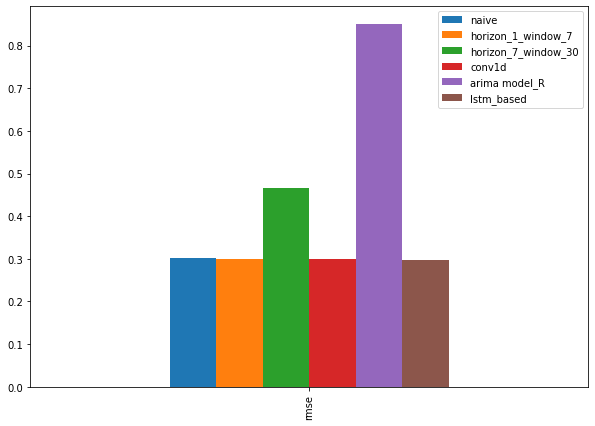

In [76]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
print(model_4_results)


pd.DataFrame({"naive": naive_results["rmse"], 
              "horizon_1_window_7": model_1_results["rmse"], 
              "horizon_7_window_30": model_2_results["rmse"],
              "conv1d":model_3_results["rmse"],
              "arima model_R":0.849516036,
              "lstm_based":model_4_results["rmse"]}, index=["rmse"]).plot(figsize=(10, 7), kind="bar");

#!zip -r /content/file.zip /content/model_experiments

In [78]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [79]:
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [89]:
waves_nbeats = df_m5_copy.copy()
for i in range(WINDOW_SIZE):
  waves_nbeats[f"waveperiod+{i+1}"] = waves_nbeats["waveperiod"].shift(periods=i+1)
waves_nbeats = waves_nbeats.filter(like='waveperiod')
waves_nbeats.dropna().head()

,waveperiod,waveperiod+1,waveperiod+2,waveperiod+3,waveperiod+4,waveperiod+5,waveperiod+6,waveperiod+7
time,,,,,,,,
2003-02,8.632883,8.398098,7.538889,6.694444,7.364454,5.267133,5.000000,5.000000
2003-03,8.099593,8.632883,8.398098,7.538889,6.694444,7.364454,5.267133,5.000000
2003-04,6.927677,8.099593,8.632883,8.398098,7.538889,6.694444,7.364454,5.267133
2003-05,6.754517,6.927677,8.099593,8.632883,8.398098,7.538889,6.694444,7.364454
2003-06,6.619085,6.754517,6.927677,8.099593,8.632883,8.398098,7.538889,6.694444


In [90]:
X = waves_nbeats.dropna().drop("waveperiod", axis=1)
y = waves_nbeats.dropna()["waveperiod"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(179, 179, 45, 45)

In [91]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

In [92]:
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [93]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 00128: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00228: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [94]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 94ms/step - loss: 0.5946 - mae: 0.5946 - mse: 0.5944


[0.5946194529533386, 0.5946194529533386, 0.5944140553474426]

In [ ]:
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

In [96]:
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
print(model_7_results)

{'mae': 0.59461945, 'mse': 0.59441406, 'rmse': 0.7709825, 'mape': 8.665789, 'mase': 0.9812587}


In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

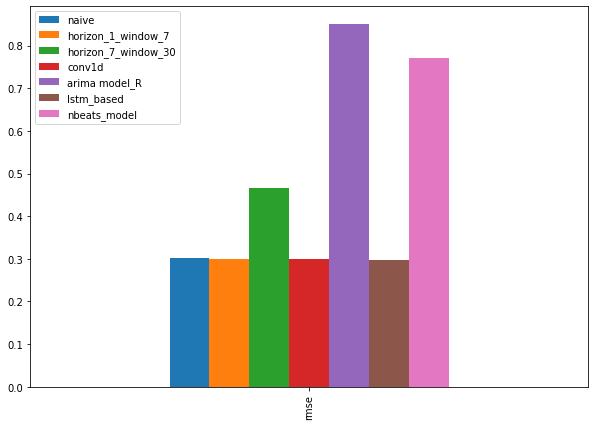

In [99]:
pd.DataFrame({"naive": naive_results["rmse"], 
              "horizon_1_window_7": model_1_results["rmse"], 
              "horizon_7_window_30": model_2_results["rmse"],
              "conv1d":model_3_results["rmse"],
              "arima model_R":0.849516036,
              "lstm_based":model_4_results["rmse"],
              "nbeats_model":model_7_results["rmse"]}, index=["rmse"]).plot(figsize=(10, 7), kind="bar");